# Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from PIL import Image
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Dataset

In [2]:
class FaceSketchDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.photos = sorted(os.listdir(os.path.join(root_dir, 'photos')))
        self.sketches = sorted(os.listdir(os.path.join(root_dir, 'sketches')))

    def __len__(self):
        return len(self.photos)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.root_dir, 'sketches', self.sketches[idx])
        photo_path = os.path.join(self.root_dir, 'photos', self.photos[idx])
        
        sketch = Image.open(sketch_path).convert('L')  # Convert to grayscale
        photo = Image.open(photo_path).convert('RGB')  # Convert to RGB
        
        if self.transform:
            sketch = self.transform(sketch)
            photo = self.transform(photo)

        return sketch, photo

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FaceSketchDataset('/kaggle/input/person-face-sketches/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = FaceSketchDataset('/kaggle/input/person-face-sketches/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# CGAN Architecture

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),  # Input: 1x64x64 (sketch)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  # Output: 3x64x64 (photo)
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, stride=2, padding=1),  # Input: (sketch + photo) 4x64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, sketch, photo):
        x = torch.cat([sketch, photo], dim=1)  # Concatenate along channel dimension
        return self.model(x)


# Save and Load Model

In [5]:
import os
# Create a directory for saving model checkpoints
os.makedirs("saved_model", exist_ok=True)
def save_checkpoint(generator, discriminator, epoch):
    torch.save(generator.state_dict(), f"saved_model/generator_epoch_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"saved_model/discriminator_epoch_{epoch}.pth")
    print(f"Models saved for Epoch {epoch+1}!")

In [6]:
def load_model(generator, path):
    generator.load_state_dict(torch.load(path, map_location=device))
    generator.eval()  # Set to evaluation mode
    print("Model loaded successfully!")

# Show Images

In [7]:
def show_images(images, epoch, title):
    images = (images + 1) / 2  
    grid = make_grid(images, nrow=8, padding=2, normalize=True)
    np_img = grid.cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(np_img)
    plt.title(f'{title} - Epoch {epoch + 1}')
    plt.axis('off')
    plt.show()

# Training

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


Epoch [1/15], Step [100/646], D Loss: 0.8920, G Loss: 3.1952
Epoch [1/15], Step [200/646], D Loss: 0.7861, G Loss: 6.3758
Epoch [1/15], Step [300/646], D Loss: 0.7274, G Loss: 4.3784
Epoch [1/15], Step [400/646], D Loss: 0.7937, G Loss: 3.4225
Epoch [1/15], Step [500/646], D Loss: 0.5506, G Loss: 2.5766
Epoch [1/15], Step [600/646], D Loss: 0.4951, G Loss: 3.6479


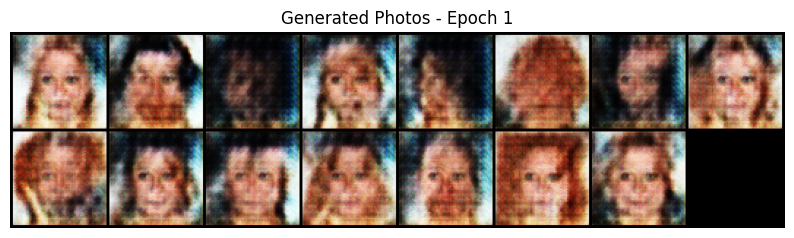

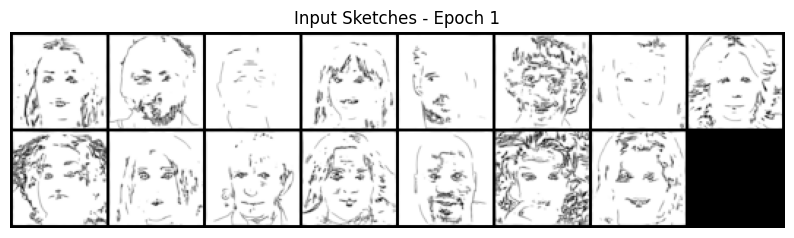

Models saved for Epoch 1!
Epoch [2/15], Step [100/646], D Loss: 1.4584, G Loss: 7.3849
Epoch [2/15], Step [200/646], D Loss: 0.2415, G Loss: 3.0934
Epoch [2/15], Step [300/646], D Loss: 0.4756, G Loss: 5.0003
Epoch [2/15], Step [400/646], D Loss: 0.4183, G Loss: 3.4584
Epoch [2/15], Step [500/646], D Loss: 0.2868, G Loss: 2.8324
Epoch [2/15], Step [600/646], D Loss: 0.3067, G Loss: 3.1479


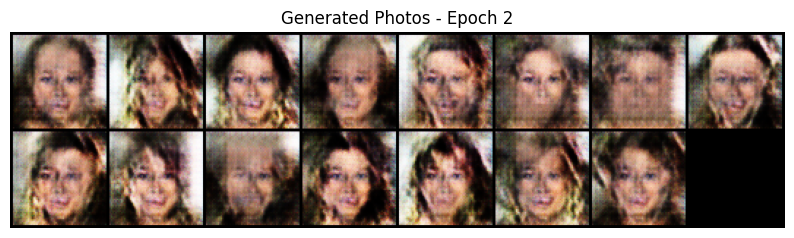

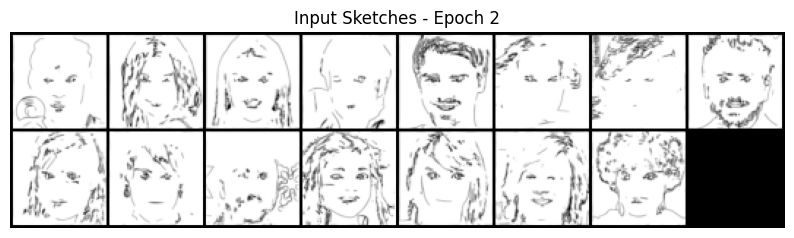

Models saved for Epoch 2!
Epoch [3/15], Step [100/646], D Loss: 0.4627, G Loss: 2.9827
Epoch [3/15], Step [200/646], D Loss: 0.3747, G Loss: 3.7418
Epoch [3/15], Step [300/646], D Loss: 0.6347, G Loss: 7.6003
Epoch [3/15], Step [400/646], D Loss: 0.3756, G Loss: 4.9033
Epoch [3/15], Step [500/646], D Loss: 0.8150, G Loss: 8.1600
Epoch [3/15], Step [600/646], D Loss: 0.2903, G Loss: 4.2234


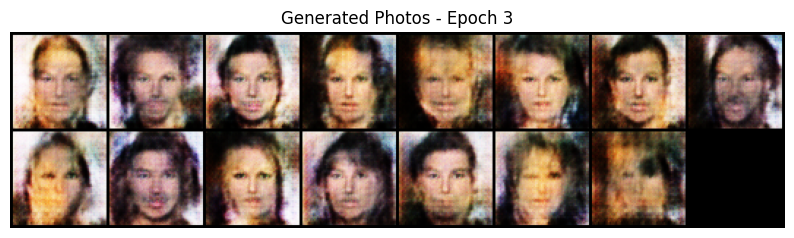

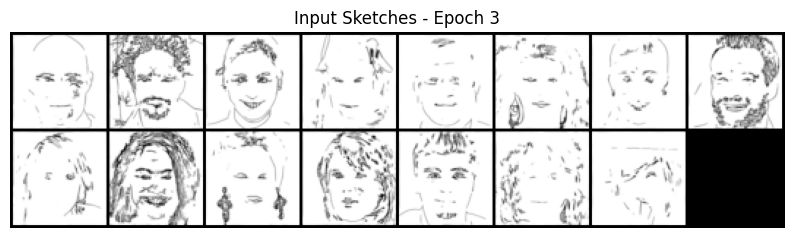

Models saved for Epoch 3!
Epoch [4/15], Step [100/646], D Loss: 0.6741, G Loss: 2.0404
Epoch [4/15], Step [200/646], D Loss: 0.5288, G Loss: 3.7007
Epoch [4/15], Step [300/646], D Loss: 0.1345, G Loss: 5.3221
Epoch [4/15], Step [400/646], D Loss: 0.2319, G Loss: 3.4327
Epoch [4/15], Step [500/646], D Loss: 0.2677, G Loss: 3.7178
Epoch [4/15], Step [600/646], D Loss: 0.1737, G Loss: 3.0841


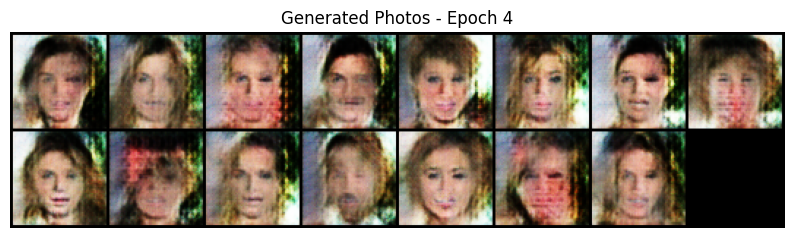

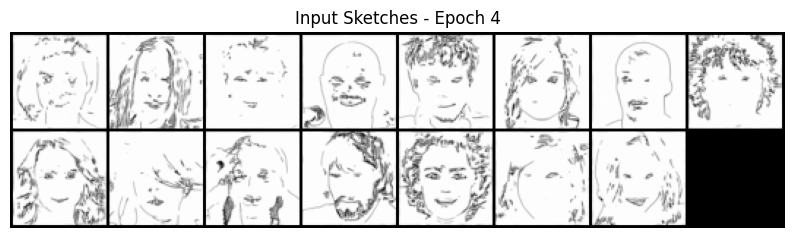

Models saved for Epoch 4!
Epoch [5/15], Step [100/646], D Loss: 0.2098, G Loss: 4.3978
Epoch [5/15], Step [200/646], D Loss: 0.1567, G Loss: 5.9709
Epoch [5/15], Step [300/646], D Loss: 0.1643, G Loss: 4.5183
Epoch [5/15], Step [400/646], D Loss: 0.1503, G Loss: 5.3722
Epoch [5/15], Step [500/646], D Loss: 0.1906, G Loss: 5.2958
Epoch [5/15], Step [600/646], D Loss: 0.2724, G Loss: 4.5192


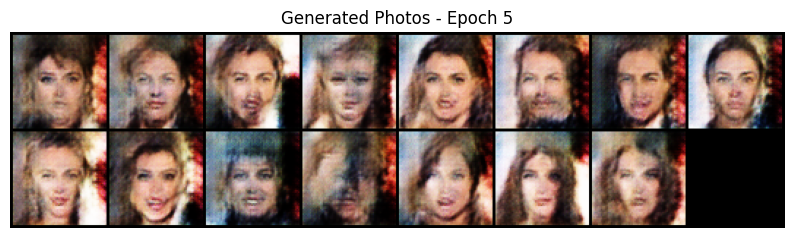

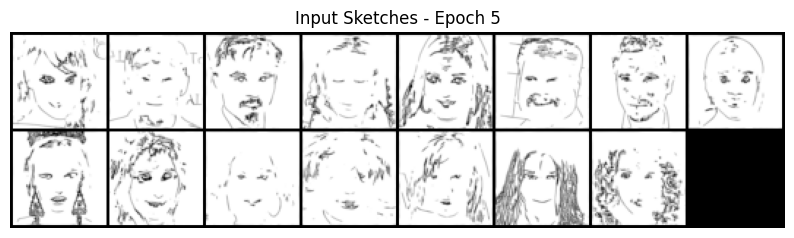

Models saved for Epoch 5!
Epoch [6/15], Step [100/646], D Loss: 0.1597, G Loss: 5.8697
Epoch [6/15], Step [200/646], D Loss: 0.1402, G Loss: 4.7932
Epoch [6/15], Step [300/646], D Loss: 0.3131, G Loss: 4.9786
Epoch [6/15], Step [400/646], D Loss: 1.0664, G Loss: 0.8236


In [ ]:
def train_gan(num_epochs):
    for epoch in range(num_epochs):
        for i, (sketches, real_photos) in enumerate(train_loader):
            sketches = sketches.to(device)
            real_photos = real_photos.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(sketches.size(0), 1).to(device)
            fake_labels = torch.zeros(sketches.size(0), 1).to(device)

            outputs = discriminator(sketches, real_photos)
            d_loss_real = criterion(outputs, real_labels)

            fake_photos = generator(sketches)
            outputs = discriminator(sketches, fake_photos.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            outputs = discriminator(sketches, fake_photos)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], "
                      f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        # Visualize generated images after each epoch
        show_images(fake_photos, epoch, title="Generated Photos")
        show_images(sketches, epoch, title="Input Sketches")

        # Save the models at the end of each epoch
        save_checkpoint(generator, discriminator, epoch)

# Start the training with visualization and saving models
train_gan(num_epochs=15)